# Assignment 3
In this assignment you will implement a non-trivial problem that processes Big Data. To facilitate its processing in a regular computer, the actual amount of data will not be big, but the techniques that you will implement would scale to larger volumes of data.

This assignment is worth 15% of the total assessment of the unit.

This assignment relates to the following Learning Outcomes:
* Apply Map-reduce techniques to a number of problems that involve Big Data.
* Apply Big Data techniques to data mining.


**Submission deadline: Friday Week 12, 11:55pm**

The following code unzips the data stored in tweets.zip. This is the same data you used in Assignment 2.

In [2]:
import zipfile
from pathlib import Path
if not Path('10000 tweets-NEW.json').exists():
    print("Unzipping tweets")
    with zipfile.ZipFile('cleaned-tweets.zip') as myzip:
        myzip.extractall()

The following code implements a [Python generator](https://wiki.python.org/moin/Generators) that simulates a stream of tweets. You will use this iterator in some of the following tasks. The function uses the `yield` statement instead of a `return` statement so that it does not need to read the entire file into memory. By doing this, the function can work with files of  unlimited size.

In [3]:
import json
def stream_tweets():
    with open('10000 tweets-NEW.json', encoding='iso8859-1') as jfile:
        for line in jfile:
            try:
                next_tweet = json.loads(line)
            except:
                continue # yield next tweet instead of returning str
            yield next_tweet

There will be a demonstration of the use of this code in the lectures and workshops. Below is an example of how it can be used in a loop:

In [4]:
counter = 0
for s in stream_tweets():
    if counter > 3:
        break
    counter += 1
    print(s)

{'id': 'tag:search.twitter.com,2005:715690137900941312', 'objectType': 'activity', 'actor': {'objectType': 'person', 'id': 'id:twitter.com:18064228', 'link': 'http://www.twitter.com/Intelledox', 'displayName': 'Intelledox', 'postedTime': '2008-12-11T23:47:55.000Z', 'image': 'https://pbs.twimg.com/profile_images/485981380585603072/inMuMtJ7_normal.png', 'summary': "Intelledox's mobile-ready digitalization software helps over 1 million people to do business faster, smarter & efficiently Digitalize your business process now!", 'links': [{'href': 'http://www.intelledox.com', 'rel': 'me'}], 'friendsCount': 486, 'followersCount': 549, 'listedCount': 24, 'statusesCount': 1188, 'twitterTimeZone': 'Canberra', 'verified': False, 'utcOffset': '39600', 'preferredUsername': 'Intelledox', 'languages': ['en'], 'location': {'objectType': 'place', 'displayName': 'Canberra, Australia'}, 'favoritesCount': 55}, 'verb': 'post', 'postedTime': '2016-04-01T00:00:00.000Z', 'generator': {'displayName': 'HubSpot'

## Task 1 (5 marks)
Fill the gaps in the class below that processes the stream and issues the following standing queries:

* (1 mark) The length of the shortest tweet and the length of the longest tweet so far.
* (2 marks) The twitter ID of the person who has posted most tweets in the last 1000 posts.
* (2 marks) The twitter ID of the most active twitter when we apply an exponentially decaying window with $c=10^{-3}$ and a threshold of 0.5.

In your implementation, make sure that the system scales well to unlimited streams, and answer the following question:

1. How much memory do you need to reserve to keep the information about each of the standing queries?

# TODO: this question needs fixing
part 3, make the algorithm better

In [16]:
import numpy as np
from collections import Counter
from pprint import pprint
class StreamProcessor:
    
    shortest = None
    longest = None
    frequency = []
    active = Counter()
    
    def _step_rval(self):
        return {'shortest': self.shortest,
               'longest': self.longest,
               'most_frequent': max(Counter(self.frequency)),
               'most_active': max(self.active, key=lambda x: self.active[x])}
    
    # end of class variables
    def step(self, item):
        """Process one item from the stream and return the answers to the
        standing queries as a Python dictionary with the following keys:
          - shortest
          - longest
          - most_frequent
          - most_active
        """
        userid = item['actor']['id']
        post = item['body']
        l = len(post)
        self.frequency.append(userid)
        self.frequency = self.frequency[-1000:] # cut off entries before last 1000.
        
        # apply decay to all users
        # TODO: find mathematical equivalent of this decay in growth
        # so dont have to iterate over whole counter, only increment the growth indicator
        # (IE each time add a larger number, and occasionally when numbers get too big 
        # multiply down to managable size, and reset growth indicator)
        for k in self.active:
            self.active[k] = self.active[k]*.999 # (1-10**(-3))
        # add this tweet to activity
        self.active[userid] += 1
        
        # initialize lowest and highest
        if self.shortest is None:
            self.shortest = l
            self.longest = l
            return self._step_rval() # no more calculation
        
        if l<self.shortest:
            self.shortest = l
        if l > self.longest:
            self.longest = l
        
        return self._step_rval()

The following code will apply the stream processor to the first 5 elements of the stream.

In [17]:
counter = 0
stream = StreamProcessor()
for s in stream_tweets():
    if s == 'Tweet error':
        continue
    if counter >= 5:
        break
    counter += 1
    print(stream.step(s))

{'shortest': 140, 'longest': 140, 'most_frequent': 'id:twitter.com:18064228', 'most_active': 'id:twitter.com:18064228'}
{'shortest': 138, 'longest': 140, 'most_frequent': 'id:twitter.com:188921458', 'most_active': 'id:twitter.com:188921458'}
{'shortest': 127, 'longest': 140, 'most_frequent': 'id:twitter.com:97578801', 'most_active': 'id:twitter.com:97578801'}
{'shortest': 127, 'longest': 140, 'most_frequent': 'id:twitter.com:97578801', 'most_active': 'id:twitter.com:3266593548'}
{'shortest': 127, 'longest': 140, 'most_frequent': 'id:twitter.com:97578801', 'most_active': 'id:twitter.com:225568917'}


## Task 2 (5 marks)
Apply the minhashing techniques we have covered in week 7 to determine the set of near-duplicates among the tweet posts. For this exercise use only the first 500 tweet posts (so that you do not need to wait too long). To complete this assignment you can reuse code from the lecture notebooks and from the workshop exercises. Use your judgement to determine the parameters and answer the following questions:

1. What value of $k$ did you use to represent the $k$-shingles and why?
2. Did you hash the $k$-shingles and why?
3. If you hashed the $k$-shingles, how many buckets did you use and why?
4. How many hashes did you use for minhashing, how many buckets, and why?
5. How many bands and rows did you use for locality-sensitive hashing and why?

In [99]:
from itertools import combinations, count
from collections import namedtuple
import pandas as pd
from matplotlib import pyplot as plt
% matplotlib inline
# implementation:
# k_shingles function creates a zip of k copies of the tweet, each
# offset by one more then the previous and returns the columns. EG:
#          >>> k_shingles('testing', 3)
# internally:  v v v v v
#comprehension t e s t i
#   function   e s t i n
#   returns    s t i n g
# zip transposes
# map applies the hashing function
#          <<< {'tes','est','sti','tin','ing'} 
# 
# note: zip only returns values while arguments have elements at the
# current index.
# 
# this method of computing k_shingles is memory intensive, but has
# a lower time complexity (and is very pythonic). The memory shouldnt
# be an issue as tweets are all below 280 characters (so (280-k) * k)
def k_shingles(tweet, k, h=lambda x:''.join(x)):
    if len(tweet) < k:
        return tweet
    else:
        return set(map(h, zip(*[tweet[i:len(tweet)-(k-i-1)] for i in range(k)])))

# print(k_shingles('0123456789', 3))
# print(k_shingles('test', 3, h=hash))
# print(k_shingles('tesa', 3, h=hash))

# for easier debugging
Tweet = namedtuple('Tweet', ['body','id'])

tweetset = {t['actor']['id']:Tweet(t['body'], t['actor']['id']) for _, t in zip(range(50), stream_tweets())}
#tweetset = {i: Tweet(a, i) for i, a in enumerate(['abc','abcd','zeqr', 'abacus', 'c', 'abcde'])}
buckets = 2**64
k = 20
hash_count = 40
# creates functions of the form hash_function(1) = lambda s:hash(s+str(1))%buckets
#                             # hash_function(1)('test') = some integer between 0 and buckets.
hash_function = lambda i: lambda s: hash(str(s)+str(i))%buckets
# print(hash_function(3)('a'))
hash_functions = [hash_function(i) for i in range(hash_count)]
# define signature as a named tuple (instead of an anonymous tuple)
# helps for knowing what objects are (as python is duck typed)
Signature = namedtuple('Signature', ['id', 'hash_values'])

def similarity(signature1, signature2):
    similar = 0
    for v1, v2 in zip(signature1.hash_values, signature2.hash_values):
        if v1 == v2:
            similar += 1
    return similar / hash_count

# basically a constructor for the Signature namedtuple
def signature(tweet, k=k, hash_functions=hash_functions):
    return Signature(tweet.id, tuple(min(map(h, k_shingles(tweet.body, k))) for h in hash_functions))
        # does not return a generator of the signature as it may need to be accessed many times.

# signatures = [signature(v) for k, v in tweetset.items()]

def signature_sensitivity_hashing(signature, row_size=3, hash_function=hash_functions[0]):
    bands = len(signature.hash_values)//row_size
    new_hash_values = tuple([hash_function(signature.hash_values[i*row_size:(i+1)*row_size]) for i in range(bands)] +
                                    [hash_function(signature.hash_values[:-len(signature.hash_values)%bands])])
    # sometimes the second slice will return [:0] meaning the same hash is always returned
    # (when hash_count%row_size==0)
    # this is accounted for below:
    return Signature(signature.id, new_hash_values
                     [:-1 if len(signature.hash_values)%row_size==0 else len(new_hash_values)])

# a = signature_sensitivity_hashing(signatures[0], row_size=10)
# b = signatures[0]
# print(len(a.hash_values), len(b.hash_values)/10)

def similarity_sets(tweetset, k, hash_functions, row_count, similarity_cutoff, precalc_similarities=None):
    # when similarity cutoff < 0; this will essentially s
    hash_count = len(hash_functions)
    signatures = [signature_sensitivity_hashing(signature_sensitivity_hashing(signature(tweet,
                                                                                        k=k,
                                                                                        hash_functions=hash_functions),
                                                                              row_size=row_count,
                                                                              hash_function=hash_functions[0]))
                  for i, tweet in tweetset.items()]

    # create lookup table of similarities (and dont repeat calculation if it was provided)
    if precalc_similarities is None:
        sims = {key1 : {key2 : None for key2 in tweetset} for key1 in tweetset}
        for s1, s2 in combinations(signatures, 2):
            sim = similarity(s1, s2)
            sims[s1.id][s2.id] = sim
            sims[s2.id][s1.id] = sim # it is a symmetric matrix
    else:
        sims = precalc_similarities
        
    if similarity_cutoff < 0:
        return [set(tweetset.keys())], sims
    sets = []
    for tweet in tweetset:
        added=False
        for s in sets:
            for t in s:
                # min clustering
                if sims[tweet][t] > similarity_cutoff:
                    s.add(tweet)
                    added=True # go on to the next tweet
                    break
            if added:
                break
        if not added:
            sets.append(set([tweet]))
    return sets, sims
        
    
    
# for t1, t2 in combinations([signature(v) for k, v in tweetset.items()], 2):
#     sim = similarity(t1, t2)
#     count = 0
#     if sim > 0:
#         print(t1.id, t2.id, sim)

# sets, similarities = similarity_sets(tweetset, k=20, hash_functions=hash_functions,
#                                      row_count=2, similarity_cutoff=.1)[0]

# some experimentation
hash_functions = [hash_function(i) for i in range(20)] # 50 hashing functions
df = pd.DataFrame(columns=['k','row_count','cutoff','groups'])
for k in range(3, 10):
    k*= 3
    for row_count in range(1, 5):
        prev_calc = None
        for similarity_cutoff in range(10):
            similarity_cutoff/=10
            sets, prev_calc = similarity_sets(tweetset, k=k, hash_functions=hash_functions,
                                         row_count=row_count, similarity_cutoff=similarity_cutoff,
                                         precalc_similarities=prev_calc)
            df = df.append({'k':float(k), 'row_count':float(row_count), 'cutoff':similarity_cutoff, 'groups':sets}, ignore_index=True)
            

In [100]:
df['max_group_length'] = list(map(lambda x:max(map(len, x)), df['groups'].values))

## Task 3 (5 marks)
Implement a MapReduce version of PageRank **using combiners** as described in the lectures of week 9. The MapReduce version should incorporate teleporting with $\beta=0.85$. 

For this assignment we will use Python's built-in functions `map` and `reduce`. For example, the following code is a Python version that uses MapReduce to compute the sum of squares of the numbers in a list:

In [34]:
from functools import reduce
def my_square(x):
    return x**2

def my_sum(x,y):
    return x+y

my_list = [1, 2, 3, 4, 5]

def mapreduce(a_list):
    temp = map(my_square, a_list) # Note that map returns an iterator, not a list
    return reduce(my_sum, temp)

mapreduce(my_list)

55

In [16]:
1+2**2+3**2+4**2+5**2

55

The above Python code is not efficient and it does not take advantage of parallel computing units (feel free to search the Web for parallel versions) but it will serve for this assignment. 

Note that `map` returns a Python iterator and not a list and there are operations that cannot be performed on it. For example, you cannot select a slice or compute the length:

In [37]:
temp = map(my_square, my_list)
print(len(temp))

TypeError: object of type 'map' has no len()

In [38]:
temp = map(my_square, my_list)
print(temp[0:2])

TypeError: 'map' object is not subscriptable

For this assignment, use an artificially generated network such as the one used in the workshop of week 9. The code is:

In [102]:
def generate_network(n, sparsity):
    "Return a transition matrix with n nodes"
    # Fill the matrix
    result = np.zeros((n,n))
    for i in range(int(n*n - n*n*sparsity)):
        x = np.random.randint(n)
        y = np.random.randint(n)
        result[x,y] = 1
        
    # Normalise the results
    for c in range(n):
        degree = np.sum(result[:, c])
        if degree > 0:
            result[:, c] /= degree
    return result

In [118]:
generate_network(5,0.7)

array([[0. , 0.5, 0. , 0. , 0. ],
       [0. , 0.5, 0. , 0. , 1. ],
       [0. , 0. , 0. , 0.5, 0. ],
       [1. , 0. , 1. , 0. , 0. ],
       [0. , 0. , 0. , 0.5, 0. ]])

* In your demonstration, generate a network with 20 nodes and compute the PageRank of each node. 
* Your solution must include a graph that shows how the PageRank changes at each iteration.
* Do not attempt to remove dead ends (to simplify this exercise).
* What size of blocks did you use for your solution?

In [129]:
M = generate_network(20, 0.7)

The following code does not use MapReduce (it's based on the lecture notebook). Use it for your reference.

PR after 14 iterations:
[[0.03      ]
 [0.09123336]
 [0.07197902]
 [0.1107532 ]
 [0.06877418]]


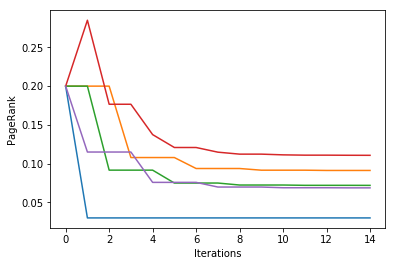

In [162]:


epsylon = 0.0001
beta = 0.85
page_count = 5
M = generate_network(page_count, 0.7)
PR = np.ones((pages, 1)) / page_countt
iterations = 0
oldPR = np.zeros((pages,1))
allPR = [PR]
while max(np.abs(oldPR-PR)) > epsylon:
    oldPR = PR
    PR = beta*(np.dot(M, PR)) + (1-beta)/pages*np.ones((pages,1))
    allPR.append(PR)
    iterations += 1
print("PR after %i iterations:" % iterations)
print(PR)
for p in range(pages):
    data = [onePR[p,0] for onePR in allPR]
    plt.plot(data)
plt.xlabel("Iterations")
plt.ylabel("PageRank")
plt.show()

Write the solution with MapReduce below.

In [257]:
Constants = namedtuple('Constants', ['epsillon','beta', 'page_count'])
c = Constants(.0001, .85, len(M))


def map_pagerank(key, value, constants=c):
    print('map:\n\tkey: {}\n\tvalue: {}'.format(key, value))
    # input------------------------------------
    # key: (page, pagerank)
    # value: itterable of outgoing links
    for v in value:
        print('map return:\n\tkey: {}\n\tvalue: {}'.format(v, (key[1] / len(value) * constants.beta, ())))
        yield v, (key[1] / len(value) * constants.beta, ()) # transversal
    print('map return:\n\tkey: {}\n\tvalue: {}'.format(key[0], ((1-constants.beta) / constants.page_count, value)))
    yield key[0], ((1-constants.beta) / constants.page_count, value) # teleportation
    # output-----------------------------------
    # key: page
    # value: (pagerank, outgoing links)
    

def reduce_pagerank(key, values, constants=c):
    print('reduce:\n\tkey: {}\n\tvalues: {}'.format(key, values))
    # input-----------------------------------
    # key: page
    # value: (pagerank, outgoing links)
    outlinks = []
    pr = 0
    for p, o in values:
        outlinks += list(o[1])
        pr += o[0]
    yield (p, pr), tuple(outinks)
    # output-----------------------------------
    # key: (page, pagerank)
    # value: tuple of outgoing links


def prepare_reduce(key_value_pairs, constants=c):
    # function takes all key value pairs and groups them by key.
    rval = {}
    for key, value in key_value_pairs:
        if key not in rval:
            rval[key] = set()
        rval[key].add(value)
    for key in rval:
        yield (key, 1/constants.page_count), tuple(rval[key])


# epsylon beta page_count M 
def prepare_map(network_matrix):
    for pagenumber, row in enumerate(network_matrix):
        yield (pagenumber, 1/len(network_matrix)), tuple(i for i in range(len(network_matrix)) if row[i] != 0)
      

In [260]:
tuple(zip(*map(map_pagerank, *zip(*prepare_map(M)))))

map:
	key: (0, 0.2)
	value: ()
map return:
	key: 0
	value: (0.030000000000000006, ())
map:
	key: (1, 0.2)
	value: (2,)
map return:
	key: 2
	value: (0.17, ())
map:
	key: (2, 0.2)
	value: (0, 4)
map return:
	key: 0
	value: (0.085, ())
map:
	key: (3, 0.2)
	value: (0, 1, 4)
map return:
	key: 0
	value: (0.056666666666666664, ())
map:
	key: (4, 0.2)
	value: (1,)
map return:
	key: 1
	value: (0.17, ())


(((0, (0.030000000000000006, ())),
  (2, (0.17, ())),
  (0, (0.085, ())),
  (0, (0.056666666666666664, ())),
  (1, (0.17, ()))),)